In [3]:
import os
import sys
import numpy as np
import matplotlib
matplotlib.use('nbagg')
#from matplotlib import style
#style.use('ggplot')
import matplotlib.pyplot as plt

from photutils import Background2D, MedianBackground

import photutils

from scipy import optimize

from astroscrappy import detect_cosmics

from skimage.morphology import reconstruction
from scipy.ndimage.filters import median_filter
from scipy.ndimage import gaussian_filter
from scipy.signal import medfilt

from skimage.filters.rank import median

import astropy.units as u

from astropy.modeling.models import Gaussian2D, Polynomial2D
from astropy.modeling.fitting import LevMarLSQFitter

from astropy.coordinates import SkyCoord, match_coordinates_3d

from astroscrappy import detect_cosmics

%load_ext autoreload
%autoreload 2

from astropy.io import fits
from mmtwfs.wfs import *
from mmtwfs.zernike import ZernikeVector

In [4]:
def implot(im):
    norm = wfs_norm(im)
    plt.imshow(im, norm=norm, origin='lower')
    plt.show()

In [5]:
mmirs = WFSFactory(wfs="mmirs")

In [6]:
mmirs_file = "/Users/tim/MMT/mmtwfs/notebooks/data.fits"
f9_file = "/Users/tim/MMT/wfsdat/20170318/TREY_p500_0000.fits"
ref_file = "/Users/tim/MMT/mmtwfs/mmtwfs/data/ref_images/mmirs_camera1_ref.fits"
#mmirs_file = "/Users/tim/MMT/wfsdat/20170414/rawdata/mmirs_wfs_0275.fits"
data = check_wfsdata(mmirs_file)
#cr_mask, data = detect_cosmics(data, sigclip=4., niter=6, cleantype='medmask')

<IPython.core.display.Javascript object>


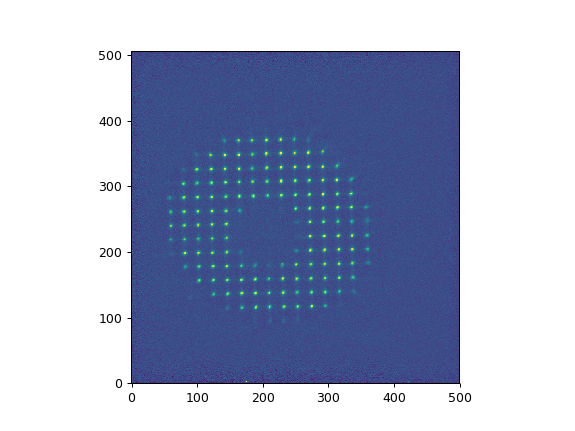

In [8]:
implot(data)

<IPython.core.display.Javascript object>


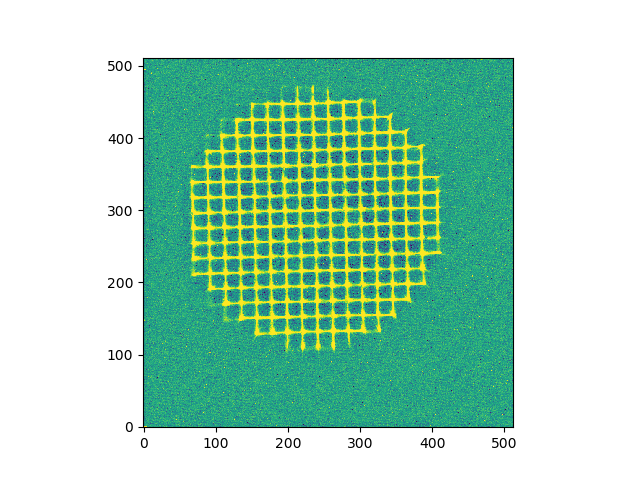

In [252]:
d = data.copy()
sigma_clip = SigmaClip(sigma=3., iters=10)
bkg_estimator = MedianBackground()
bkg = Background2D(d, (12, 12), filter_size=(5, 5), bkg_estimator=bkg_estimator)
implot(d - bkg.background)

<IPython.core.display.Javascript object>


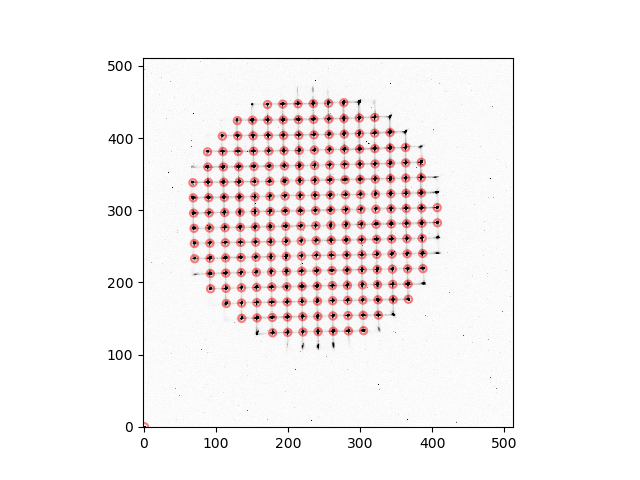

In [258]:
d = data.copy()
im = d - bkg.background
im[:5, :] = 0.0
im[:, :12] = 0.0
s = wfsfind(data, plot=True, fwhm=4.0, threshold=30.)
plt.show()

In [248]:
sf = s[s['flux'] > s['flux'].max()/3.]
sf.show_in_notebook()

idx,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
0,6,194.145160981,59.85244038,0.601966396418,-0.106867400683,0.124262265669,169.0,0.0,8386.17022315,42.366141182,-4.06754727284
1,7,243.175034886,60.3654399737,0.596143069148,-0.259190733702,0.073516614086,169.0,0.0,8724.02164639,44.5794849396,-4.1228376161
2,8,294.339915926,59.7747082442,0.586342824824,-0.381867543362,0.155939134231,169.0,0.0,7959.9762526,39.0521324889,-3.97911188509
3,10,169.582658189,74.8117559795,0.603531912362,-0.00467485232495,0.102881813247,169.0,0.0,9660.5530269,48.314440991,-4.21019239755
4,11,218.795450163,75.200748276,0.630152689567,-0.127448575334,-0.00572740091703,169.0,0.0,11798.132824,59.3039893757,-4.43270977328
5,12,268.765394567,75.4587981122,0.564972437428,-0.17403588986,-0.00223891779296,169.0,0.0,10050.3210656,53.8602602413,-4.32817111875
6,13,319.070794598,75.9134771909,0.56061890277,-0.214750265082,0.0229170470012,169.0,0.0,9090.74221441,47.8754125407,-4.20028132323
7,14,144.209971984,88.9729445312,0.581720636277,0.521406340413,0.13284125444,169.0,0.0,8274.01453777,40.8930726262,-4.02912435956
8,15,194.327576832,89.789012359,0.591567809897,-0.226859869489,-0.0249270741896,169.0,0.0,10969.7739676,56.7567041113,-4.38504291958
9,16,243.627848546,89.7399680921,0.610970770052,-0.128128656323,-0.0701509373492,169.0,0.0,9738.34977227,49.5426441966,-4.23744795523


In [178]:
xspacing, yspacing = grid_spacing(im)

<IPython.core.display.Javascript object>


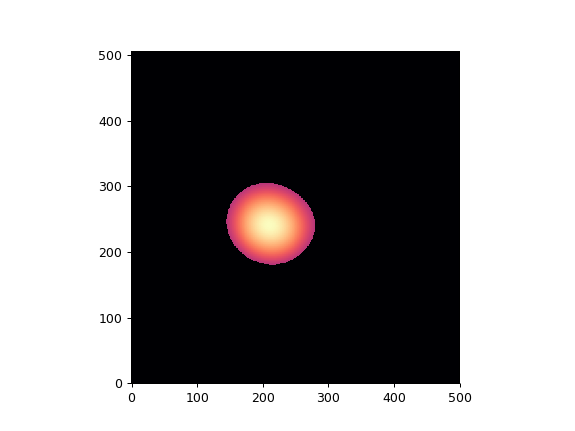

In [15]:
masked_data = data.copy()
masked_data[masked_data < 300.] = 0.0
xcen, ycen, plot = center_pupil(masked_data, mmirs.telescope.pupil_mask(), plot=True)
plt.show()

In [16]:
xcen, ycen

(211.0973735744067, 241.62204732849847)

In [259]:
apers = photutils.CircularAperture((s['xcentroid'], s['ycentroid']), r=(xspacing+yspacing)/4.)

In [260]:
masks = apers.to_mask(method='subpixel')

In [261]:
spot = np.zeros(masks[0].shape)

In [262]:
for m in masks:
    subim = m.cutout(data)
    try:
        spot += subim
    except:
        pass

<IPython.core.display.Javascript object>


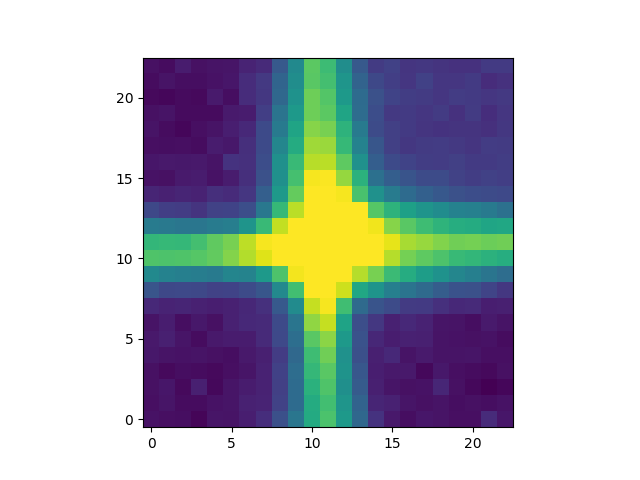

In [263]:
implot(spot)

In [264]:
g = Gaussian2D(amplitude=spot.max(), x_mean=spot.shape[1]/2, y_mean=spot.shape[0]/2) + Polynomial2D(degree=0)
fit_g = LevMarLSQFitter()
y, x = np.mgrid[:spot.shape[0], :spot.shape[1]]

In [265]:
pars = fit_g(g, x, y, spot)

In [266]:
pars.y_stddev_0.value

0.81893592801860204

In [189]:
pars

<CompoundModel5(amplitude_0=46685.329878975026, x_mean_0=11.023890156088521, y_mean_0=11.032180846448338, x_stddev_0=2.3442806133454117, y_stddev_0=2.415009077439269, theta_0=280762209584.1609, c0_0_1=-231.22327058502037)>

In [190]:
ref = mmirs.modes['mmirs2']['reference']

In [191]:
refx = (xspacing/ref['xspacing'])*ref['apertures']['xcentroid']+305 #xcen
refy = (yspacing/ref['yspacing'])*ref['apertures']['ycentroid']+247 #ycen
ref_apers = photutils.CircularAperture(
    (refx, refy),
    r=(xspacing+yspacing)/4.,
)

<IPython.core.display.Javascript object>


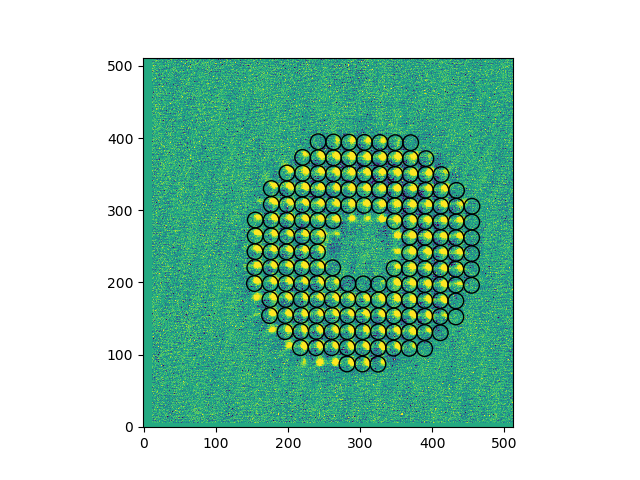

In [192]:
ref_apers.plot()
#apers.plot()
implot(im)
plt.show()

In [193]:
src_coord = SkyCoord(x=s['xcentroid'], y=s['ycentroid'], z=0.0, representation='cartesian')
ref_coord = SkyCoord(x=refx, y=refy, z=0.0, representation='cartesian')

In [194]:
idx, sep, dist = match_coordinates_3d(src_coord, ref_coord)

In [195]:
src_coord.separation(ref_coord[idx]).std().to(u.deg)

<Angle 0.7350984559803326 deg>

In [196]:
np.mean(abs(s['xcentroid'] - refx[idx]))

5.9861596492506424

In [197]:
np.mean(s['xcentroid'] - refx[idx])

4.4899420357542441

In [198]:
def fit_wfs_reference(pars, ref, spots):
    xc = pars[0]
    yc = pars[1]
    model = SkyCoord(
        representation='cartesian',
        x=ref['xcentroid'] + xc,
        y=ref['ycentroid'] + yc,
        z=0.0
    )
    measured = SkyCoord(
        representation='cartesian',
        x=spots['xcentroid'],
        y=spots['ycentroid'],
        z=0.0
    )
    idx, ang, dist = match_coordinates_3d(measured, model)
    stat = measured.separation(model[idx]).std().value
    return stat

In [199]:
scale_ref = {
    'xcentroid': (xspacing/ref['xspacing'])*ref['apertures']['xcentroid'],
    'ycentroid': (yspacing/ref['yspacing'])*ref['apertures']['ycentroid']
}
pars = [xcen, ycen]
xopt = optimize.fmin_powell(fit_wfs_reference, pars, xtol=1e-4, args=(scale_ref, s))
xopt, xcen, ycen

Optimization terminated successfully.
         Current function value: 0.426127
         Iterations: 4
         Function evaluations: 123


(array([ 291.49643898,  241.49967025]), 298.87446519913766, 240.71421449526792)

In [200]:
refx_match = refx[idx]
refy_match = refy[idx]
xoff = np.mean(s['xcentroid'] - refx_match)
yoff = np.mean(s['ycentroid'] - refy_match)
ref_coord = SkyCoord(x=refx+xoff, y=refy+yoff, z=0.0, representation='cartesian')
idx, sep, dist = match_coordinates_3d(src_coord, ref_coord)
xoff = np.mean(s['xcentroid'] - refx[idx])
yoff = np.mean(s['ycentroid'] - refy[idx])

In [201]:
dist

<Quantity [ 22.98810289, 22.57104269, 20.05958685,  2.27447797,
             2.35817348,  2.63946783,  2.39835762,  2.38618168,
             1.53651395,  2.14936285,  1.98408746,  2.31392517,
             2.04824017,  2.30014052, 19.99298487,  1.89542536,
             1.53282064,  1.68681828, 21.71609124,  2.02815796,
             1.37164355,  1.81415755,  1.98075648,  2.18359806,
             2.20302815,  1.97693871,  2.0420841 ,  1.51309048,
             1.35864236,  1.96157391,  1.23243962,  1.477647  ,
             1.38179023,  1.93140877,  2.3813703 ,  2.13499732,
             1.99782333,  2.54128715,  1.56765076,  1.14747383,
             1.27114314,  0.92216559, 21.27283813,  2.15487201,
             1.70246865,  1.31444018,  1.90773285,  1.62858563,
             2.50771349,  2.24315613,  2.3105626 ,  1.09300141,
             1.89237112,  1.32133016,  0.62367335,  0.57219861,
             1.95339772,  1.58920251,  1.36936654,  1.97381169,
             1.73178914,  1.92632189,  2

<IPython.core.display.Javascript object>


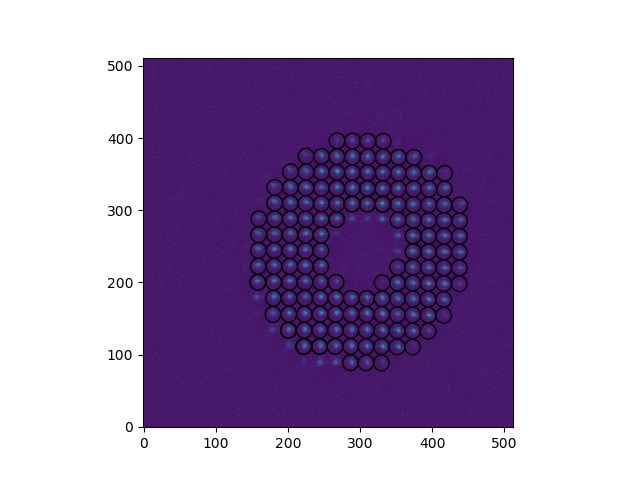

In [202]:
ref_apers = photutils.CircularAperture(
    (refx[idx]+xoff, refy[idx]+yoff),
    r=(xspacing+yspacing)/4.,
)
plt.imshow(im, origin='lower')
ref_apers.plot()
#apers.plot()
plt.show()

In [203]:
len(ref['apertures'])

162

In [204]:
ref_im = fits.open("/Users/tim/MMT/mmtwfs/mmtwfs/data/ref_images/mmirs_camera2_ref.fits")[0].data

In [221]:
ref_xsum = np.sum(ref_im, axis=0)
ref_xsum /= ref_xsum.max()
ref_ysum = np.sum(ref_im, axis=1)
ref_ysum /= ref_ysum.max()
xl = int(xcen - 2*xspacing)
xu = int(xcen + 2*xspacing)
yl = int(ycen - 2*yspacing)
yu = int(ycen + 2*yspacing)
xsum = np.sum(im[yl:yu, :], axis=0)
xsum /= xsum.max()
xtot = np.sum(im, axis=0)
xtot /= xtot.max()
ysum = np.sum(im[:, xl:xu], axis=1)
ysum /= ysum.max()
ytot = np.sum(im, axis=1)
ytot /= ytot.max()
xdiff = xtot - xsum
xdiff[xdiff < 0.25] = 0.0
ydiff = ytot - ysum
ydiff[ydiff < 0.25] = 0.0

<IPython.core.display.Javascript object>


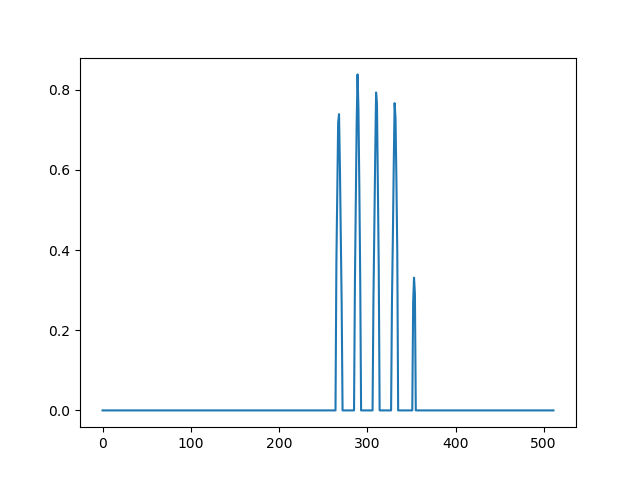

In [222]:
#plt.plot(ysum)
plt.plot(xdiff)
plt.show()

In [207]:
ndimage.measurements.center_of_mass(xdiff)

(299.63836185646653,)

In [137]:
xcen, ycen

(295.124388162137, 249.40394388393889)

In [223]:
detect_cosmics?